<div align="center">
  <h1>HMM's and Bayesian Models for the MBTA</h1>
  <br>
  <b>Lyla Fadden, Filip Piasevoli, Aaron Zampaglione, Simon Malian</b>
  <br>
  <i>Pavlos Protopapas</i>
</div>

*****

## Background/Motivation ##
We are members of a four-person team of Harvard students working alongside MBTA staff to analyze and better predict demand for public transportation. The primary goal of that project is a machine learning model to predict subway demand, accounting for recent past ridership, seasonal/cyclical effects, and sporadic events like severe weather and major events. 

### Problem Definition ###

We’ve built predictive models for MBTA ridership as part of our Capstone project, but even with two years worth of data, we’ve run into several problems when building models. One model looks to predict the change in ridership for a particular station as a function of the amount of snowfall. Snowfall, however, occurs in greater frequency for amounts of 0-3 inches than it does for greater amounts of snow like 6-10 inches. Further, there seems to be much more noise in ridership for days with low amounts of snow, possibly due to inaccurate forecasts, school closings, service delays, or other extraneous factors. A simple linear model seems too rigid and does not do a good job of imputing values for unobserved amounts of snowfall. We hope to use Gaussian Processes to better model the effect of snowfall on ridership as it considers the span of all gaussian fits constrained by the relatively low amount of days we do observe with snow.

Secondly, we look to predict the general ridership of a station on any particular day as a function of historical ridership as well as other external factors like the weather or public events. Currently, we use the predictors to build a linear model, but it suffers from overfitting to station closures, holidays, and general outliers. We hope to use both Gaussian Processes and Bayesian Linear regression to create two alternative models to which we can compare our simple linear model fit by OLS.

### Questions to Address ###

- How much can we improve our predictive accuracy by implementing stochastic methods in building our models?
- Are these stochastic methods more resilient to outliers and missing data?

### Methodology ###

- In the case of modeling ridership as a function of snowfall, we will use Gaussian Processes to create a model that incorporates the variance at individual levels of snowfall and incorporates a more dynamic range of predicted values for snowfall levels that were observed.
- We will use a Bayesian Linear Regression framework, similar to the last problem in HW7, in order to estimate the parameters of the linear models to predict ridership. We will also use Gaussian Processes in a Time Series scope to see if it improves the predictive power compared to our simple linear model.

### Data ###

- We have two years worth of MBTA entries data aggregated at 15-minute intervals for each station.
- We also have the amount of snowfall data from NOAA for each day appearing in the aforementioned data set.

In [3]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import random
import math
import time
import seaborn as sns

import pymc

import sklearn
from sklearn import cross_validation, grid_search
from sklearn import linear_model

sns.set_style("whitegrid")
sns.set_context("paper")
% matplotlib inline

## Bayesian Linear Prediction ##

### Load Data ###

In [2]:
data = pd.read_csv('../data/mbta_daily_weather_games_grouping_noholidays_weekdays.csv', low_memory=False).reset_index(drop=True)
data.head()

,locationid,service_day,entries,name,line_1,line_2,lat,lon,service_datetime,fog,...,dist_to_center,entries_weeks_ago_1,entries_weeks_ago_2,entries_weeks_ago_3,bruins_game,celtics_game,sox_game,stationid,grouping,grouping_sum_weeks_ago_1
0,1002,2013-01-03 00:00:00,5733,Andrew Square,Red,NaN,42.32955,-71.05696,2013-01-03 05:00:00,0,...,3.404767,NaN,NaN,NaN,0,0,0,1002,2,33251781
1,1002,2013-01-04 00:00:00,6125,Andrew Square,Red,NaN,42.32955,-71.05696,2013-01-04 05:00:00,0,...,3.404767,NaN,NaN,NaN,0,1,0,1002,2,33251781
2,1002,2013-01-07 00:00:00,5998,Andrew Square,Red,NaN,42.32955,-71.05696,2013-01-07 04:00:00,0,...,3.404767,NaN,NaN,NaN,0,0,0,1002,2,33251781
3,1002,2013-01-08 00:00:00,6002,Andrew Square,Red,NaN,42.32955,-71.05696,2013-01-08 04:30:00,0,...,3.404767,NaN,NaN,NaN,0,0,0,1002,2,33251781
4,1002,2013-01-09 00:00:00,6055,Andrew Square,Red,NaN,42.32955,-71.05696,2013-01-09 04:45:00,0,...,3.404767,NaN,NaN,NaN,0,1,0,1002,2,33251781


### Optimal Features ###

The optimal features used for prediction were determined from a previous experiment. Some of the feature include:

- ***entries_weeks_ago_1***: The number of entries for this station on the same day one week ago.
- ***snow_fall***: The amount of snow the fell for that day, in inches.
- ***snow_accum***: The amount of snow accumulated up to the current day. The snow accumulation was calculated using a quasi-linear decay function based on the snow fall of the previous two weeks.
- ***bruins_game***: Binary column representing if a Bruins game occurred on this day.
- ***celtics_game***: Binary column representing if a Celtics game occurred on this day.
- ***sox_game***: Binary column representing if a Red Sox game occurred on this day.

In [4]:
features = ['entries_weeks_ago_1', 'entries_weeks_ago_2', 'entries_weeks_ago_3', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'snow', 'snow_fall', 'snow_accum', 'bruins_game', 'celtics_game', 'sox_game', 'grouping_sum_weeks_ago_1']

### Helper Methods ###

In [5]:
"""
Returns the necessary training data for a particular station.

Key arguments:
station -- The station to get the data for.
"""
def station_data(station):
    # Only look at rows in which we have values.
    ix = (pd.notnull(station['entries_weeks_ago_1']).values) & \
         (pd.notnull(station['entries_weeks_ago_2']).values) & \
         (pd.notnull(station['entries_weeks_ago_3']).values)
            
    Y = station[ix]['entries'].values
    X = station[ix][features].values
    
    return Y, X

In [6]:
"""
Compares a data set using ordinary linear regression and bayesian linear regression.

Key arguments:
Y      -- The outcome variable.
X      -- The predictors (features).
beta   -- The betas from the bayesian MCMC sampling.
rstate -- The random state to use.
"""
def compare(Y, X, betas, rstate):
    # Split the data set into a train and test.
    x_train, x_test, y_train, y_test = cross_validation.train_test_split(X, Y, test_size=0.3, random_state=rstate)
    
    # Train using a grid search based on the parameters provided.
    clf = grid_search.GridSearchCV(linear_model.LinearRegression(), {}, scoring='mean_squared_error', cv=10)
    clf.fit(x_train, y_train)
    
    # Determine what the best model was.
    model = clf.best_estimator_
    
    y_pred_lsr = model.predict(x_test)
    error_lsr = np.sum(np.abs(y_pred_lsr - y_test)) / np.sum(y_test)
    
    y_pred_blr = np.array([np.sum(betas * x_test[i]) for i in xrange(len(x_test))])
    error_bsr = np.sum(np.abs(y_pred_blr - y_test)) / np.sum(y_test)
    
    return error_lsr, error_bsr

### Determine Priors ###

In order to sample from a bayesian posterior, we need to generate priors for each of our parameters (features). The priors can be uninformative or informative. In our case, we can approximate the true values using linear regression. The coefficients generated using linear regression for the entire system will act as the $mu$ for normal priors for each feature. (Even though we can approximate the true values, we're going to keep our variance relatively high.)

In [7]:
# The variances for each normal distribution for each feature.
prior_vars = {
    'entries_weeks_ago_1': 1.0,
    'entries_weeks_ago_2': 1.0,
    'entries_weeks_ago_3': 1.0,
    'month_1': 1000.0,
    'month_2': 1000.0,
    'month_3': 1000.0,
    'month_4': 1000.0,
    'month_5': 1000.0,
    'month_6': 1000.0,
    'month_7': 1000.0,
    'month_8': 1000.0,
    'month_9': 1000.0,
    'month_10': 1000.0,
    'month_11': 1000.0,
    'month_12': 1000.0,
    'snow': 100.0,
    'snow_fall': 2000.0,
    'snow_accum': 2000.0,
    'bruins_game': 10000.0,
    'celtics_game': 10000.0,
    'sox_game': 10000.0,
    'grouping_sum_weeks_ago_1': 100000.0,
}

In [8]:
"""
Determine the coefficients for the entire MBTA system using linear regression.

Key arguments:
Y -- The outcome variable.
X -- The predictors (features).
"""
def system_coefs(Y, X):
    model = linear_model.LinearRegression()
    model.fit(X, Y)
    
    coefs = model.coef_
    results = {}
    for i, feature in enumerate(features):
        results[feature] = coefs[i]
    
    return results

In [9]:
"""
Returns the PyMC priors for the entire MBTA system.

Key arguments:
stations -- All of the stations in the MBTA.
"""
def system_priors(stations):
    
    # Determine all of the outcomes and predictors for the entire system.
    Y = []
    X = []
    for locationid in np.unique(stations.locationid):
        y, x = station_data(stations[stations['locationid'] == locationid])
        Y.extend(y)
        X.extend(x)
    
    coeffs = system_coefs(Y, X)
    
    results = []
    for feature in features:
        results.append(pymc.Normal(feature, mu=coeffs[feature], tau=1.0 / prior_vars[feature]))
    
    return results

### Model Generation ###

In [10]:
"""
Generates a MAP model for a station.

Key arguments:
priors -- The priors of the entire system.
Y      -- The outcome variable.
X      -- The predictors (features).
"""
def station_model(priors, Y, X):
    # Define the pymc method which acts as the regression calculator.
    @pymc.deterministic
    def y_hat(betas=priors, X=X):
        return X.dot(np.array(betas))
    
    # The likelihood model.
    Y_hat = pymc.Normal('Y_hat', mu=y_hat, tau=1.0 / 100.0, value=Y, observed=True)
    
    distributions = [Y_hat] + priors
    
    # Generate the prior models.
    model = pymc.Model(distributions)
    model = pymc.MAP(model)
    model.fit()
    
    return model

In [11]:
"""
Runs an MCMC sampler for a station.

Key arguments:
model -- The MAP model for the station.
"""
def station_mcmc(model):
    
    # The latest pymc tries to sample on the string features. Hopefully this will be fixed in the next release.
    for key in model.__dict__.keys():
        if not isinstance(key, basestring):
            del model.__dict__[key]
            
    mcmc = pymc.MCMC(model)
    mcmc.sample(25000, 10000, 5)
    
    return mcmc

In [12]:
"""
Runs a full bayesian regression on a station and returns the mcmc sampler and the bayesian
coefficients

Key arguments:
priors -- The priors for the entire system.
Y      -- The outcome variable for this station.
X      -- The predictors (features) for this station.
"""
def station_bayesian_regression(priors, Y, X):
    # Get the stations Bayesian model.
    model = station_model(priors, Y, X)
    # Run MCMC on the model.
    mcmc = station_mcmc(model)
    
    # Get the coefficients that were generated from the MCMC.
    coefs = {}
    for feature in features:
        trace = mcmc.trace(feature)[:]
        coefs[feature] = trace.mean()
    
    return mcmc, coefs

### Bayesian Regression on One Station ###

In order to understand the process, lets run bayesian regression on one station and take a look at the MCMC results.

In [13]:
priors = system_priors(data)
harvard = data[data['locationid'] == 1035]
Y, X = station_data(harvard)
mcmc, coefs = station_bayesian_regression(priors, Y, X)

 [-----------------100%-----------------] 25000 of 25000 complete in 47.2 sec

snow_fall: -447.390807313
month_12: -1298.2372043
snow: 76.944181687
month_10: 430.42640176
month_11: 20.5686826217
month_4: -55.343549986
month_5: 338.790985746
month_6: -326.123365652
month_7: 283.228775514
month_1: -790.98887876
month_2: 1227.31128788
month_3: 315.196357506
month_8: -812.388675555
month_9: 708.037244764
sox_game: 391.103291225
grouping_sum_weeks_ago_1: 7.70729119104e-05
entries_weeks_ago_2: 0.222290898858
entries_weeks_ago_3: 0.133042735093
snow_accum: -307.367410314
bruins_game: -426.708869683
entries_weeks_ago_1: 0.186731360213
celtics_game: 902.494521627
Plotting month_11
Plotting snow_fall
Plotting month_7
Plotting entries_weeks_ago_1
Plotting sox_game
Plotting entries_weeks_ago_2
Plotting bruins_game
Plotting month_4
Plotting month_1
Plotting celtics_game
Plotting month_2
Plotting month_10
Plotting grouping_sum_weeks_ago_1
Plotting month_12
Plotting entries_weeks_ago_3
Plotting month_6
Plotting month_3
Plotting snow_accum
Plotting month_5
Plotting snow
Plotting

/Users/azampagl/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:423: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_num_figures`).
  max_open_warning, RuntimeWarning)


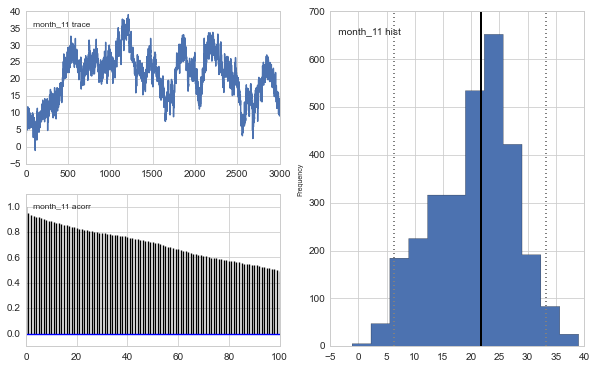

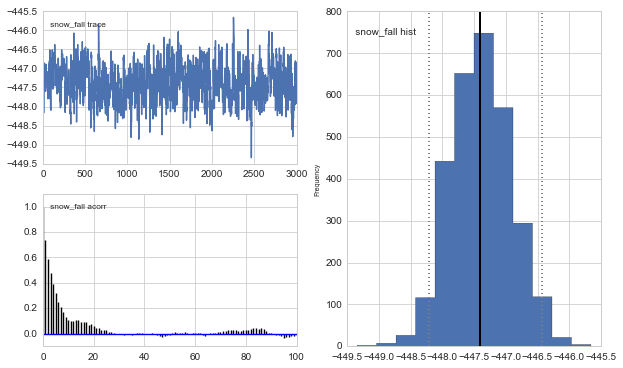

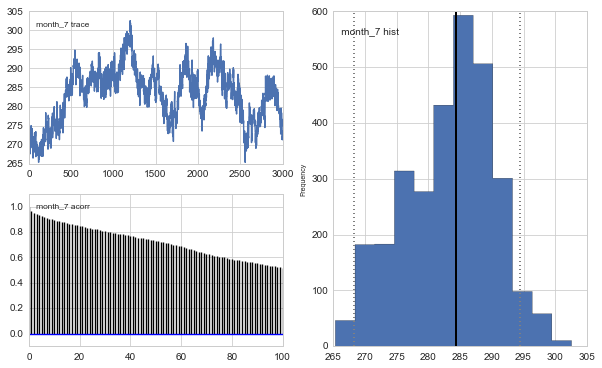

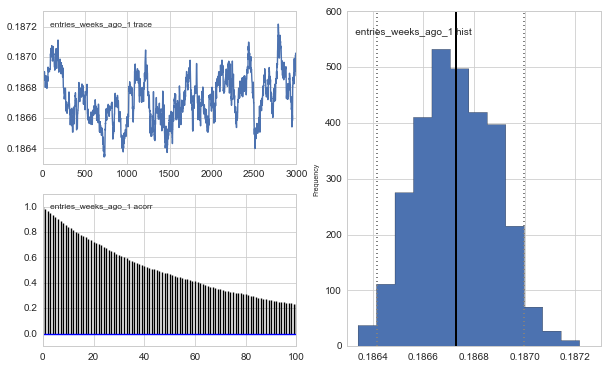

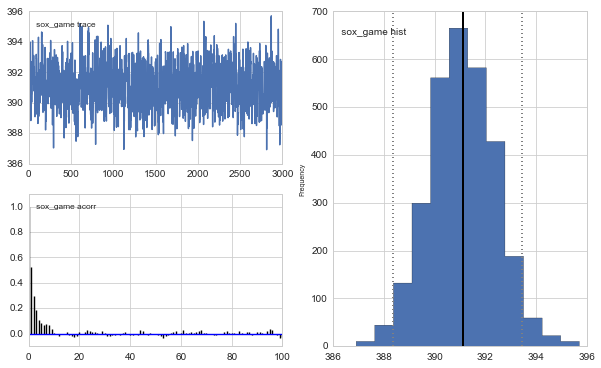

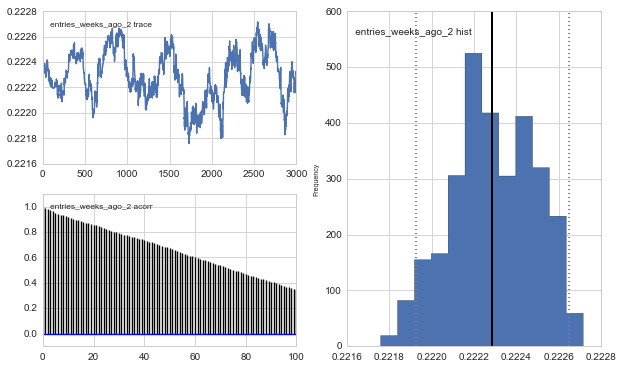

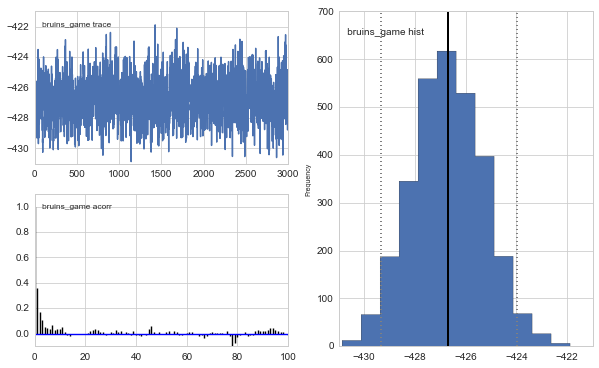

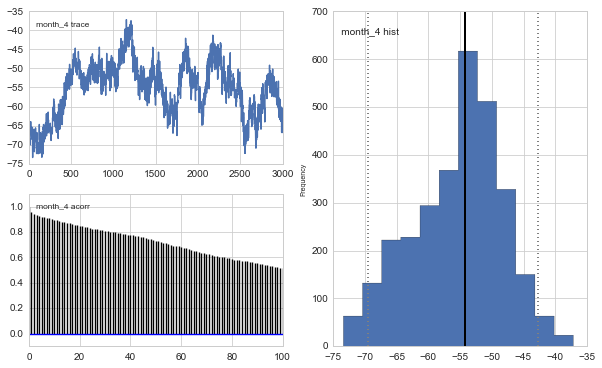

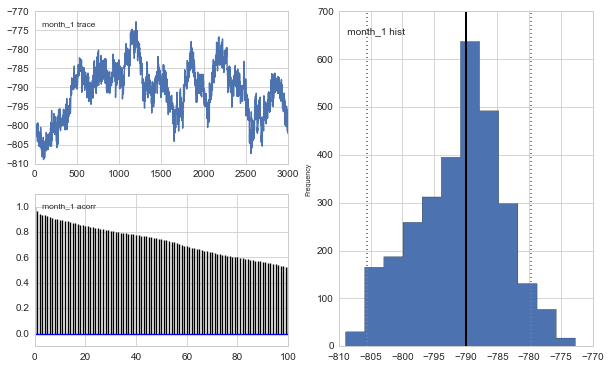

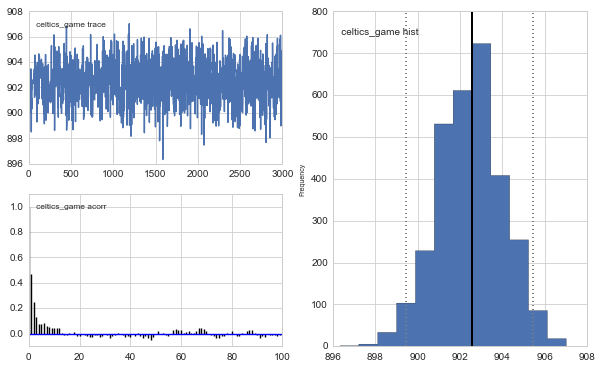

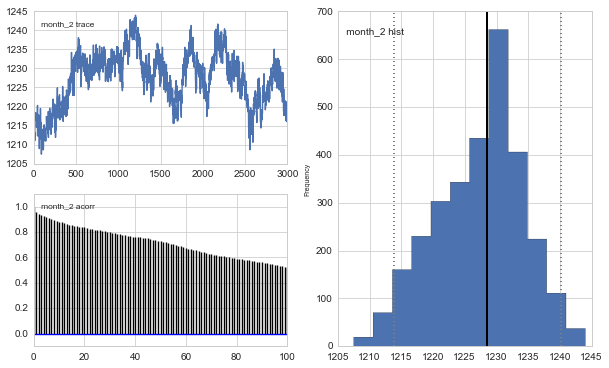

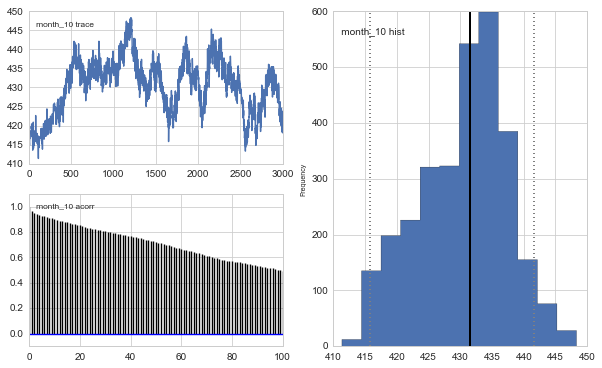

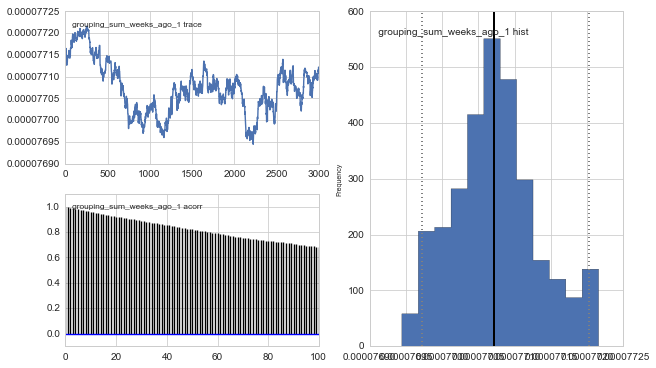

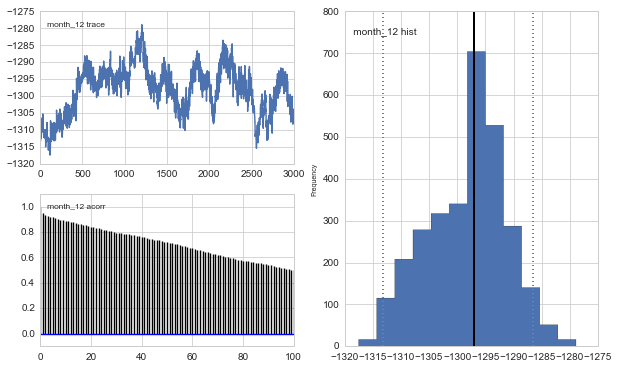

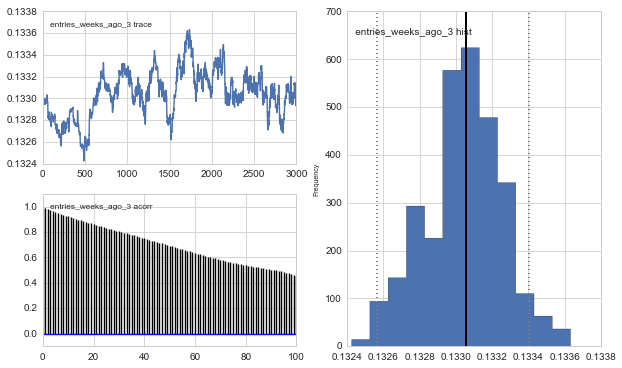

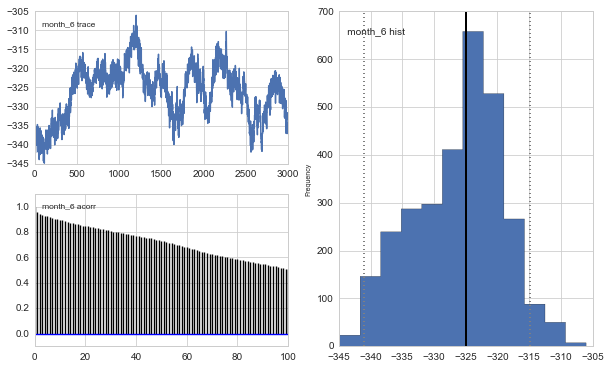

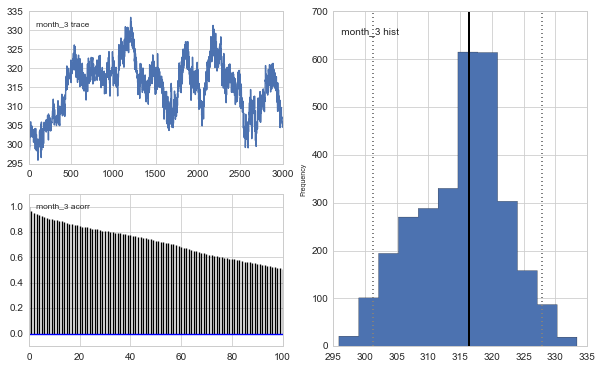

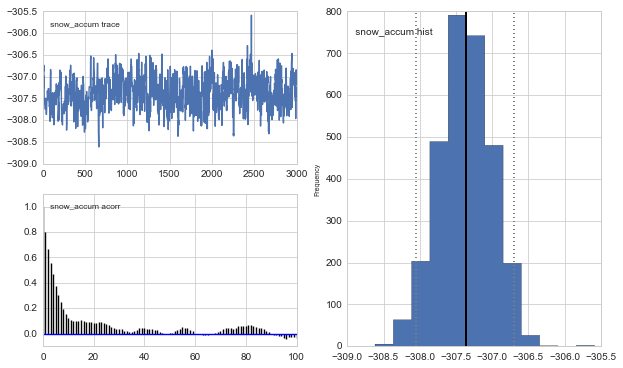

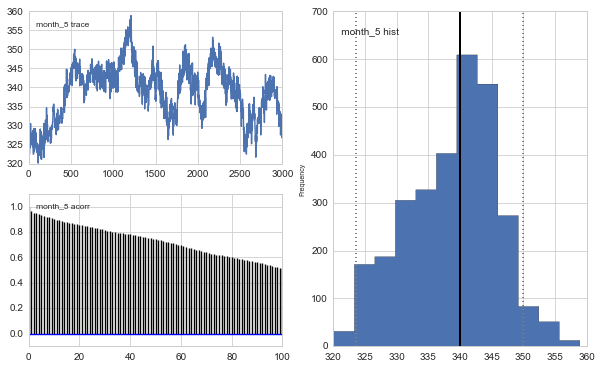

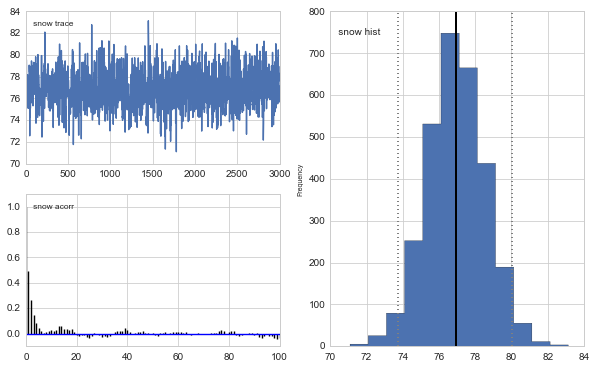

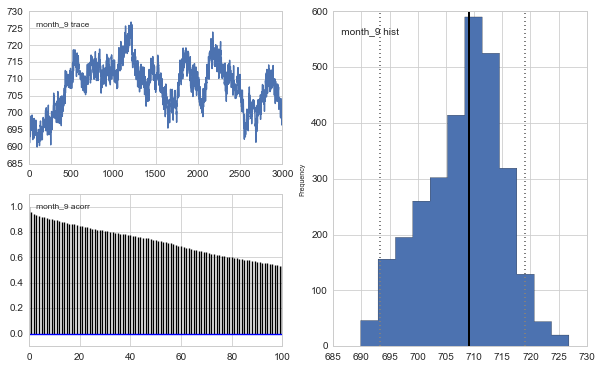

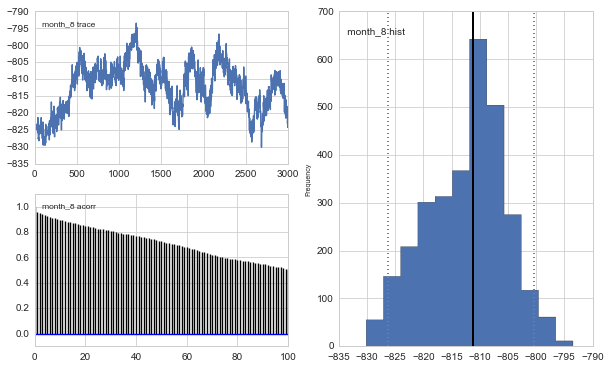

In [14]:
for k, v in coefs.iteritems():
    print(str(k) + ": " + str(v))
pymc.Matplot.plot(mcmc)

### Bayesian Regression on All Stations ###

In [ ]:
priors = system_priors(data)
results = pd.DataFrame()

for locationid in np.unique(data.locationid):
    result = pd.Series()
    
    station = data[data['locationid'] == locationid]
    result['locationid'] = locationid
    result['name'] = station['name'].iloc[0]
    
    # Get the observed entries and predictors for this station.
    Y, X = station_data(station)
    
    mcmc, coefs = station_bayesian_regression(priors, Y, X)
    
    # We have to convert the coefficient dictionary into betas that the compare method understands.
    betas = []
    for feature in features:
        betas.append(coefs[feature])
    
    # Run 50 random trials (test sets) of comparing OLS to a regression fit with the betas from MCMC.
    comparisons = []
    for rstate in xrange(50):
        comparisons.append(compare(Y, X, betas, rstate=rstate))
    
    means = np.mean(comparisons, axis=0)
    result['ols'] = means[0]
    result['blr'] = means[1]
    
    # Save the result.
    print(result['name'] + " complete...")
    results = results.append(result, ignore_index=True)

results.to_csv("bayesian-results.csv", ignore_index=True)

### Analysis of Results ###

In [15]:
results = pd.read_csv("bayesian-results-v1.csv", low_memory=False)
results.drop('Unnamed: 0', axis=1, inplace=True)
results['diff'] = results['ols'] - results['blr']
results.head()

,blr,locationid,name,ols,diff
0,0.049160,1002,Andrew Square,0.054312,0.005152
1,0.093073,1004,JFK/U Mass,0.099176,0.006102
2,0.057324,1005,North Quincy,0.061573,0.004249
3,0.049509,1006,Wollaston,0.053494,0.003985
4,0.054881,1007,Quincy Center,0.058591,0.003710


#### Best and Worst Improvements ####

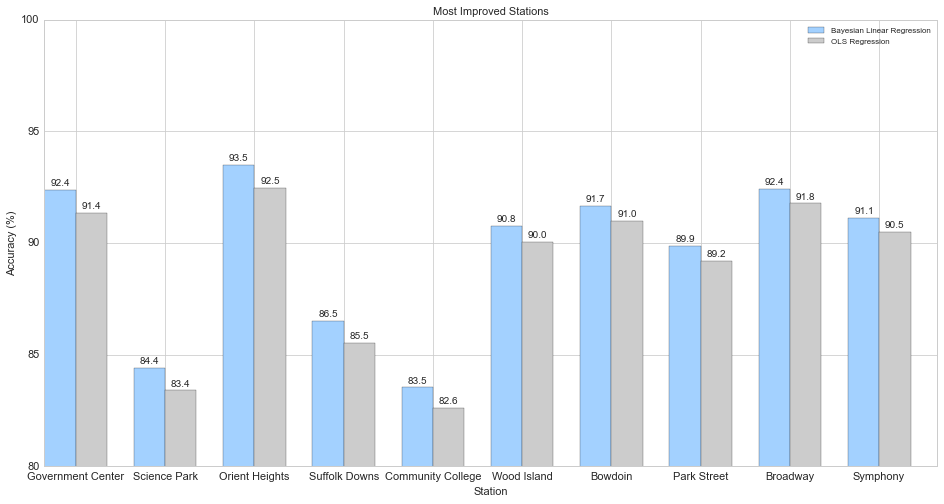

In [16]:
best_results = results.sort('diff', ascending=False)[:10]

n = len(best_results)

names = best_results['name'].values
ols_accuracy = (1.0 - best_results['ols'].values) * 100
blr_accuracy = (1.0 - best_results['blr'].values) * 100

ind = np.arange(n)
width = .35

fig, ax = plt.subplots(figsize=(16, 8))
rects1 = ax.bar(ind, blr_accuracy, width, color='#A3D1FF')
rects2 = ax.bar(ind+width, ols_accuracy, width, color='#CCCCCC')

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2., height + .1, '%.1f'%height, ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

ax.set_title('Most Improved Stations')
ax.set_xlabel('Station')
ax.set_ylabel('Accuracy (%)')

ax.set_xticks(ind+width)
ax.set_xticklabels(names, {'size':'11'})

ax.set_ylim([80, 100])

ax.legend( (rects1[0], rects2[0]), ('Bayesian Linear Regression', 'OLS Regression') )

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(11)

plt.show()

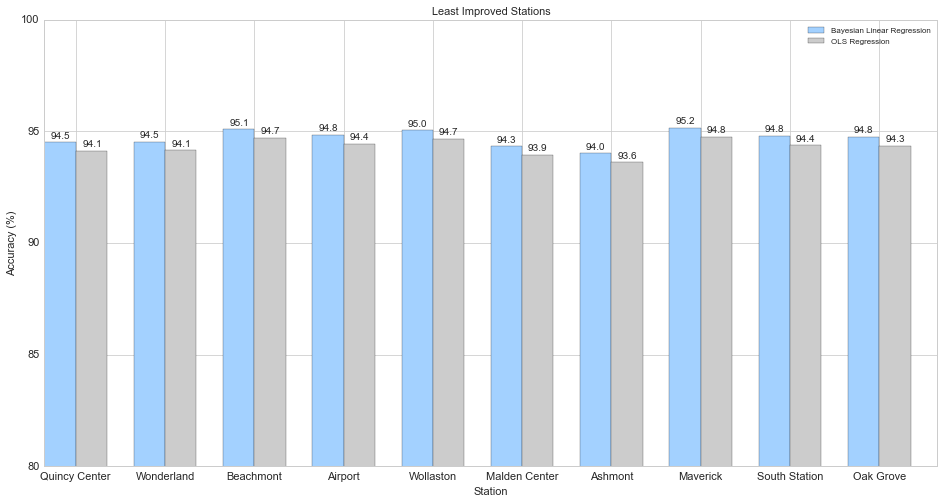

In [17]:
worst_results = results.sort('diff', ascending=True)[:10]

n = len(best_results)

names = worst_results['name'].values
ols_accuracy = (1.0 - worst_results['ols'].values) * 100
blr_accuracy = (1.0 - worst_results['blr'].values) * 100

ind = np.arange(n)
width = .35

fig, ax = plt.subplots(figsize=(16, 8))
rects1 = ax.bar(ind, blr_accuracy, width, color='#A3D1FF')
rects2 = ax.bar(ind+width, ols_accuracy, width, color='#CCCCCC')

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2., height + .1, '%.1f'%height, ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

ax.set_title('Least Improved Stations')
ax.set_xlabel('Station')
ax.set_ylabel('Accuracy (%)')

ax.set_xticks(ind+width)
ax.set_xticklabels(names, {'size':'11'})

ax.set_ylim([80, 100])

ax.legend( (rects1[0], rects2[0]), ('Bayesian Linear Regression', 'OLS Regression') )

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(11)

plt.show()

#### Overall Results ###
All station predictions improved using the bayesian linear regression versus oridnary least squares. However, overall we only saw a .5% increase in accuracy.

In [18]:
print("Bayesian Linear Regression Accuracy: " + str(100 - round(np.mean(results.blr) * 100, 2)))
print("Ordinary Linear Regression Accuracy: " + str(100 - round(np.mean(results.ols) * 100, 2)))

Bayesian Linear Regression Accuracy: 92.89
Ordinary Linear Regression Accuracy: 92.35


#### Outliers ###
Unfortuantely, a few outliers still exists (> 10% error). Further analysis will have executed on these stations to further increase their prediction accuracy.

In [19]:
results.sort('blr', ascending=False).head(n=10)

,blr,locationid,name,ols,diff
43,0.164728,1074,Community College,0.173942,0.009213
37,0.155837,1060,Science Park,0.166061,0.010224
11,0.135031,1015,Suffolk Downs,0.144900,0.009869
57,0.105949,1101,Riverside,0.111998,0.006049
29,0.101431,1052,Park Street,0.108125,0.006694
35,0.097486,1058,Prudential,0.103610,0.006124
1,0.093073,1004,JFK/U Mass,0.099176,0.006102
9,0.092283,1013,Wood Island,0.099594,0.007311
33,0.088853,1056,Symphony,0.095154,0.006301
52,0.084713,1083,Roxbury Crossing,0.090177,0.005464


# Training HMM's to Predict MBTA Ridership

We saw in lecture that Hidden Markov Models can be used to model time series with $n$ hidden states and $m$ observed states. Building off of research we did to predict how many people will ride the T on any given day, we saw an opportunity to build a model to predict ridership in real-time. Instead of predicting total ridership for a today, the goal of this project was to use the Baum-Welch algorithm, which utilizes the Expectation-Maximization framework, to learn the transition and emission probabilities of the Hidden Markov Model that predicts ridership at any time of the day. 

## The Baum-Welch Algorithm

Let $a_{ij}=P(X_t=j | X_{t-1}=1)$ be the probability of transitioning from hidden state $j$ at time $t-1$ to hidden state $i$ at time $t$, $b_j(y_t)=P(Y_t=y_t | X_t=j)$ be the probability of observing $y_t$ at time $t$ assuming the hidden markov model is in state $j$ at time $t$, and  let $\pi_i=P(X_1=i)$ be the probability that the sequence starts in hidden state $i$. The Baum-Welch algorithm finds $\theta^*= argmax_\theta P(Y|\theta)$ where $Y$ is the sequence of observed states and $\theta=(A,B,\pi)$ where $A,B$ are the matrices of transition and emission probabilities, respectively.

Recall the forwards and backwards algorithms...

**Forwards:** Computes the probability of the HMM being in hidden state $i$ at time $t$ and observing the sequence of $Y's$ given the parameters $\theta$. 

Let $\alpha(1)=\pi_i b_i(y_1)$
$$\alpha_i(t)=P(Y_1=y_1, Y_2=y_2, ..., Y_t=y_t, X_t=i | \theta)$$
$$\alpha_j(t+1)=b_j(y_{t+1})\sum^N_{i=1} \alpha_i(t) a_{ij}$$

**Backwards:** Computes the probability of observing the sequence $Y_t+1,..., Y_T$ where $T$ is the number of total observations assuming that the HMM is in state $i$ at time $t$ and $\theta$ is given. 

Let $\beta_i(T)=1$
$$\beta_i(t)=P(y_{t+1}=y_{t+1}, ..., Y_T=y_t | X_t=i, \theta)$$
$$\beta_i(t)=\sum^n_{j=1}\beta_j(t+1) a_{ij} b_j(y_{t+1})$$


**Algorithm:**

- Initialize $\theta$, using prior information about the parameters if they are known, otherwise you can randomly initialize. Note, that the dimensions of the matrices imply the number of hidden and observed states. Thus $A$ is an $n$ x $n$ matrix where $n$ is the number of hidden states and $B$ is an $n$ x $m$ matrix where $m$ is the number of observed states in the sequence.

- **Expectation step:** Define $$\gamma_i(t)=P(X_t=i | Y,\theta)=\frac{\alpha_i(t) a_{ij} \beta_j(t+1) b_j(y_{t+1})}{ \sum^n_{j=1}\alpha_j(t) \beta_j(t)}$$ as the probability that the HMM is in state $i$ at time $t$. Looking at the equation, it's clear to see that this is just the proportion of being in hidden state $i$ at time $t$ compared to the cumulative probability of all hidden states at time $t$. Also, define $$\xi_{ij}=P(X_t=i,X_{t+1}=j | Y,\theta)=\frac{\alpha_i(t) a_{ij} \beta_j(t+1) b_j(y_{t+1})}{\sum^n_{k=1} \alpha_k(t) \beta_k(t)}$$ be the probabilities that the problem goes from hidden state $i$ at time $t$ to hidden state $j$ at time $t+1$.

- **Maximization/Update step:** Given that we've determined discrete probabilities for the hidden states and their transitions defined with $\gamma$ and $\xi$, we can update the parameters in $\theta$. Let...
$$\pi_i*=\gamma_i(1)$$
$$a_{ij}^*=\frac{\sum^{T-1}_{t=1} \xi_{ij}(t)}{\sum^{T-1}_{t=1} \gamma_i(t)}$$

This is essentially updating the transition matrix by computing the ratio of cumulative transition probabilities of transitions from hidden state $i$ to state $j$ across all $T$ to the sum of probabilities of being in hidden state $i$ across all $T$.

$$b_i^*(v_k)=\frac{ \sum^T_{t=1} 1(y_t=v_k)*\gamma_i(t)}{\sum^T_{t=1}\gamma_i(t)}$$

Where $1(y_t=v_k)$ is the indicator that $v_k$ is observed at time $t$ and $b_i^*(v_k)$ is the number of times the observed state is $v_k$ while the HMM is in hidden state $i$.

## HMM in the MBTA Context

Certain stations experience prolonged periods of traffic beyond what can be normally expected like following a Red Sox game. Kenmore Station is one of the stations most affected by this type of phenomenon. Even when there is not an obvious cause of prolonged traffic like a Red Sox game, there are sporadic periods of higher than expected traffic. From an MBTA operations perspective normal staffing situations are prepared to handle typical amounts of station traffic, but it would be extremely helpful to be able to predict whether periods of higher traffic will continue for the next 15 minutes so that employees can be adequately stationed.

While there are HMM's that can produce numerical output based on Gaussian distributions or mixtures of Gaussian distribution, that would not work in the context of this problem. Below is an image showing the average ridership at Kenmore where the red line shows the mean value at that 15-minute interval and the blue shading represents one standard deviation from the mean at that time interval. Note that the standard deviation is widest during the volatile rush hour periods. 

![wed_station](wed_station.png)
We're not so interested in predicting the raw number of entries at any given time. Instead, when the entries at a given time are in the upper limits of what we've previously observed at that time period (ie at the highest portion of blue shading at that time interval), we want to predict whether or not the next period will continue to have entries much higher than expected. Conversely, if during an extended period of normal ridership there is an unexpected surge of entries for one period, you may want to predict if entries will regress back to normal in the next period.

A simplistic way to frame this problem is to train an HMM with 3 observed states; lower than expected traffic, normally expected traffic, and higher than expected traffic. We will have to decide how to process the data to determine the cutoff quantiles for the 3 observed states, and we will have to train different numbers of hidden states to test how it fits the data.

**Note: ** I will perform my analysis on the Kenmore Station data, because of its very special distinction of having Fenway Park traffic. A properly-trained HMM should be able to identify periods of heightened traffic that Kenmore experiences at various times of the day.

## Processing the Data

I chose to process the data in python due to the ease and familiarity of the Pandas module.

###Read In Data


In [4]:
gate=pd.read_csv('gatecounts_edit_1315.csv')

#kenmore: 1059
sample=gate[gate['locationid']==1059]
## Consider only weekdays
sample=sample[sample['weekday']<5]

Note the format of the data. We've subsectioned the dataset to only contain Kenmore. Each row contains the aggregated entries for the 15-minute interval in *servicetime_fraction* on the date in *servicedate*.

In [128]:
sample.head()

,Unnamed: 0,locationid,entries,servicedate,servicetime_fraction,weekday,month
92040,92040,1059,6,2013-01-01 00:00:00,5.50,1,1
92041,92041,1059,2,2013-01-01 00:00:00,5.75,1,1
92042,92042,1059,5,2013-01-01 00:00:00,6.00,1,1
92043,92043,1059,16,2013-01-01 00:00:00,6.25,1,1
92044,92044,1059,8,2013-01-01 00:00:00,6.50,1,1


In [150]:
## These helper functions will be used to compute the quantiles of entries for each time interval. 
# They didn't need to be explicitly defined as they're one-line commands, but this provided enhanced readability.
def lower_fifteen(a):
    return np.percentile(q=15,a=a.values)

def upper_fifteen(a):
    return np.percentile(q=85,a=a.values)

def lower_thirty(a):
    return np.percentile(q=30,a=a.values)

def upper_thirty(a):
    return np.percentile(q=70,a=a.values)

**Note:** We had other helper functions for other quantiles throughout my work but they became deprecated as we found their corresponding HMM's fit horribly. I've removed them from above and did not include them in the aggregation below to focus on the quantiles that matter.

In [152]:
'''
agg_sample is a reference dataframe that holds the median and quantiles for each time interval.
We will reference this df to compute which observed state the sequence is in.

'''

agg_sample=sample[['entries','servicetime_fraction']].groupby('servicetime_fraction').agg([np.median,lower_fifteen,lower_thirty,upper_thirty,upper_fifteen])

agg_sample=agg_sample.reset_index()
agg_sample.head()


servicetime_fraction  entries                                             \
                          median  lower_fifteen  lower_thirty  upper_thirty   
0                  5.00        4              2             2             5   
1                  5.25       22             17            20            25   
2                  5.50        6              3             4             8   
3                  5.75       19             13            16            22   
4                  6.00       22             15            19            26   

                  
   upper_fifteen  
0              7  
1             27  
2             10  
3             26  
4             29

In [ ]:
# only look at normal times. Excludes the weird 3 am entries when the T isn't technically running
sample=sample[(sample['servicetime_fraction']>=5.00)&(sample['servicetime_fraction']<=24.00)]

**Comment:**

Below I plot the histogram of entrices at various time intervals. These are equivalent to looking at a slice of the plot we presented above with the mean entries in red and the standard deviation of entries in blue. Notice that some of the time intervals have very narrow distributions. We need to use cutoffs for our observed states that properly demarcate normal ridership from higher of lower than expected traffic. For example, for a distribution with very small variance, the difference between entries at the 60th quantile and the 40th quantile may only span 40 entries. Compare that to a distribution with a very large variance, the difference in entries is closer to 120 entries.


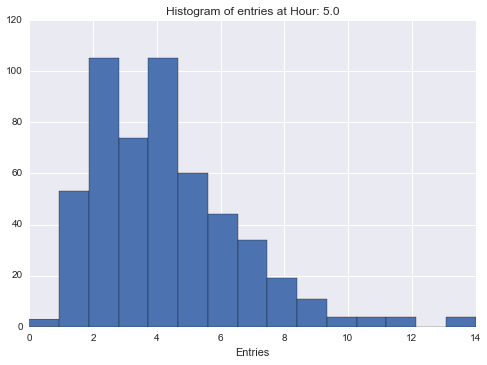

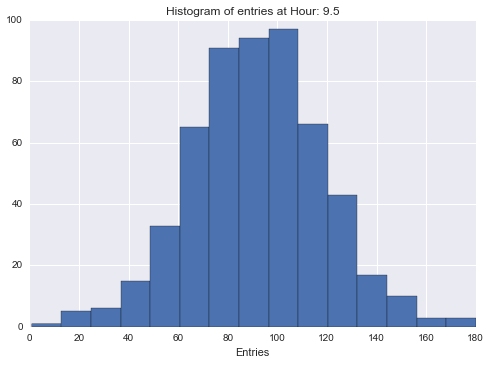

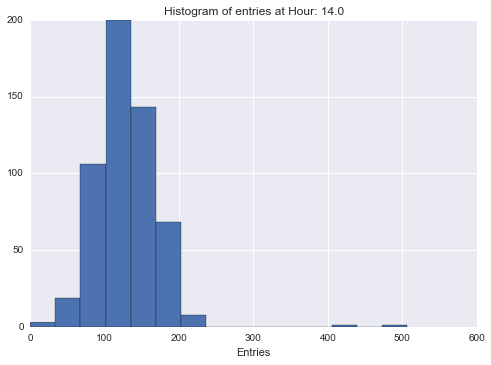

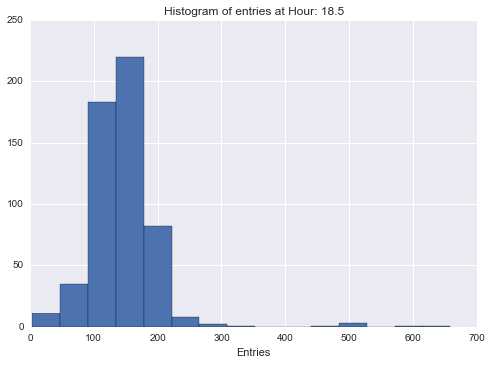

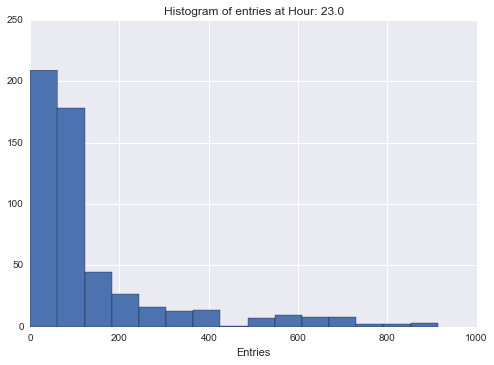

In [13]:
g=sample[['entries','servicetime_fraction']].groupby('servicetime_fraction')
count=0
for name, group in g:
    if(count%18==0):
        plt.hist(group['entries'].values,bins=15)
        plt.title('Histogram of entries at Hour: '+str(name))
        plt.xlabel('Entries')
        plt.show()
    
    count+=1
    

## Defining the HMM

Below are three functions we used to generate the observed state in each row of my dataset. The functions generate 3, 4, and 5 observed states, respectively. The code after the cell only proceeds with the function that generated 3 observed states because that was the number we saw modeled the data best. The other functions remain here to show the cutoffs we used to generate the other sequences of observed states.

The observed states at each slice are the lowest 15% of entries (much slower than expected), the highest 15% of entries (much busier than expected), and the middle 70% of entries (within a reasonable range of expected entries). These cutoffs are designed to make sure we that there is an appreciable difference between the states we label as busy and slow in the slices of time where the distributions are very narrow.

Other set-ups we tried included...
- 4 observed states: lowest 15%, 15%-50%, 50%-85%, and the highest 15%.
- 5 observed states: lowest 15%, 15%-30%, 30%-50%, 50%-70%, 70%-85%, and the highest 15%.

With each configuration of observed states, we tried varying numbers of hidden states. The easiest models to interpret are the ones with the same number of hidden states as there are observed states. For example, the model with 3 hidden and 3 observed states can be easily interpreted. The hidden states represent the station being in periods of slow, normal, and busy traffic while the observed states are the realization of hidden state. 

Commonly, the station may be in a normal state, but a sudden influx of riders in one fifteen minute period, maybe due to a large group of Harvard students entering Harvard Square station, would result in the observed state being 'higher than expected'. The underlying hidden state in this case isn't that the station is in a busy period, so we would want an HMM that can detect this behavior and would hopefully predict that ridership would return to a normal observed state in the following period. The naive model against which we will compare the HMM is a naive model that predicts the observed state at time $t$ by simply assuming that the observed state will be the same as it was at time $t-1$. The naive predictions are just a translation of the actual series by one time period as seen below.

![naive_pred](naive_pred.png)

In [153]:
# expects row passed to be a tuple
# generates 3 possible states
def find_state(row):
    time=row[1]['servicetime_fraction']
    entries=row[1]['entries']
    
    #print entries
    #print time
    
    agg_row=agg_sample[agg_sample['servicetime_fraction']==time]
    
    if entries<=agg_row['entries']['lower_fifteen'].values[0]:
        return 1;
    
    elif (entries>agg_row['entries']['lower_fifteen'].values[0])&(entries<agg_row['entries']['upper_fifteen'].values[0]):
        return 2;
    else:
        return 3;
    
# generates 4 possible states
def find_state_4(row):
    time=row[1]['servicetime_fraction']
    entries=row[1]['entries']
    
    #print entries
    #print time
    
    agg_row=agg_sample[agg_sample['servicetime_fraction']==time]
    
    if entries<=agg_row['entries']['lower_fifteen'].values[0]:
        return 1;
    
    elif (entries>agg_row['entries']['lower_fifteen'].values[0])&(entries<=agg_row['entries']['median'].values[0]):
        return 2;
    elif (entries>agg_row['entries']['median'].values[0])&(entries<=agg_row['entries']['upper_fifteen'].values[0]):
        return 3;
    else:
        return 4;
    
## generate 5 possible states
def find_state_5(row):
    time=row[1]['servicetime_fraction']
    entries=row[1]['entries']
    
    #print entries
    #print time
    
    agg_row=agg_sample[agg_sample['servicetime_fraction']==time]
    
    if entries<=agg_row['entries']['lower_fifteen'].values[0]:
        return 1;
    elif (entries>agg_row['entries']['lower_fifteen'].values[0])&(entries<=agg_row['entries']['lower_thirty'].values[0]):
        return 2;
    elif (entries>agg_row['entries']['lower_thirty'].values[0])&(entries<=agg_row['entries']['upper_thirty'].values[0]):
        return 3;
    elif (entries>agg_row['entries']['upper_thirty'].values[0])&(entries<agg_row['entries']['upper_fifteen'].values[0]):
        return 4;
    else:
        return 5;
    

In [154]:
'''
Add a column to the dataframe that maps the entries at that time interval to the proper observed state.

'''
obs_state_3=map(find_state,sample.iterrows())
# obs_state is the observed state based on lower_percentile, upper_percentile
# obs_state_qtr is the observed state based on lower_quarter, upper_quarter
sample['obs_state_3']=obs_state_3
sample.head()

,Unnamed: 0,locationid,entries,servicedate,servicetime_fraction,weekday,month,obs_state_3
92040,92040,1059,6,2013-01-01 00:00:00,5.50,1,1,2
92041,92041,1059,2,2013-01-01 00:00:00,5.75,1,1,1
92042,92042,1059,5,2013-01-01 00:00:00,6.00,1,1,1
92043,92043,1059,16,2013-01-01 00:00:00,6.25,1,1,1
92044,92044,1059,8,2013-01-01 00:00:00,6.50,1,1,1


In [158]:
# Save the obs_state series for each day in a matrix. Each row of the matrix is one day
# Only taking days with full observations, no closures or irregular times. Need 76 time intervals

obs_matrix=[]
#sox_vector=[]
for group in sample.groupby('servicedate'):
    ser=list(group[1]['obs_state_3'])
    #game_binary=group[1].iloc[0]['sox_game']

    if(len(ser)==76):
        obs_matrix.append(ser)
        #sox_vector.append(game_binary)

#sanity check
print len(obs_matrix)
#print len(sox_vector)

501


In [137]:
import csv

In [ ]:
#write as one big matrix
with open("observed_states/obs_state_3_1059.csv", "wb") as f:
    writer = csv.writer(f)
    writer.writerows(obs_matrix)
    
''' 
with open("observed_states/obs_state_3_1059_sox.csv", "wb") as f:
    writer = csv.writer(f)
    writer.writerows([sox_vector])
'''

## Training HMM's in MATLAB

We considered using scikit-learn's hmmlearn package to train our HMM. It has functions to train both Multinomial output and Gaussian output HMM's. However, after prolonged use and reading issues on the package's Github repo, we found it to be severely deprecated and under-maintained to the point that results were unreliable. We opted to train our HMM's in MATLAB instead as its HMM functions were much more robust, were decently fast, and were well-documented. IPython has a bridge module that allows us to run MATLAB code in IPython cells via the MATLAB server, but it is not supported for 32-bit Windows operating systems. We could have run it on a group member's Mac, but one of our fellow students said her experience with running MATLAB code in IPython was typically 3 times slower than running MATLAB in its IDE. Considering the models sometimes took an hour and a half to train, we trained our models completely outside the IPython notebook and present the pertinent code below. 

We imported the csv output here to present our findings.

###Helper Functions

See the detailed documentation of each function for a summary of the use, inputs, and outputs.

##Script to train and evaluate HMMs

Again, most of the code here shows the analysis performed after training an HMM with 4 hidden states and 3 observed states. The sizes of the initial transition and emission matrices tell the function how many hidden and observed states to train for, as explained earlier.

Once the matrices are trained, the predict_next_obs function predicts the observed state at time $t+1$ using the following procedure...
- Use MATLAB's hmmdecode function to generate the posterior probability of the station being in each hidden state at time t; $H^{(t)}=(h_1^{(t)},h_2^{(t)},h_3^{(t)},h_4^{(t)})$ where $1=\sum_{i=1}^n h_i^{(t)}$ and $n=4$ is the number of hidden states. 
- Compute the probability of observing state $j$ at time $t+1$ given the posterior probabilities of the hidden states at time $t$ as well as the emission and transition matrices. This is the weighted average of the probability of observing each state from all transitions of hidden states.
$$P(y^{(t+1)}=j | H^{(t)}, A, B)= h_1^{(t)}(a_{11} b_1(j)+a_{12} b_2(j)+a_{13} b_3(j)+a_{14} b_4(j) )+h_2^{(t)}(a_{21} b_1(j)+a_{22} b_2(j)+a_{23} b_3(j)+a_{24} b_4(j) )+h_3^{(t)}(a_{31} b_1(j)+a_{32} b_2(j)+a_{33} b_3(j) +a_{34} b_4(j))+h_4^{(t)}(a_{41} b_1(j)+a_{42} b_2(j)+a_{43} b_3(j)+a_{44} b_4(j) )$$


- The predicted observed state is $\hat{y}^{(t+1)}= argmax$ $P(y^{(t+1)}=j | H^{(t)}, A, B)$ over all observed states $1\leq j \leq m=3$, $j\in \mathbf{Z}$

Refer to the diagram below for a visual interpretation of the HMM prediction procedure.

![hmm_diag](hmm_diag.png)

## Final HMM model: 

Following the process below, I arrived upon the HMM with 4 hidden states and 3 observed states. The transition and emission matrices are...

$$ A= \left( \begin{array}{ccc}
0.9587 & 0.0023 & 0.039 & 0.0 \\
0.0 & 0.9598 & 0.0402 & 0.0 \\
0.0 & 0.0106 & 0.9722 & 0.0171\\
0.0 & 0.0 & 0.0531 & 0.9469\end{array} \right) $$

$$ B= \left( \begin{array}{ccc}
0.1195 & 0.6893 & 0.1911 \\
0.5764 & 0.4218 & 0.0017  \\
0.0711 & 0.8812 & 0.0477\\
0.0 & 0.3243 & 0.6757 \end{array} \right) $$

## Evaluating the HMMs

Below, I read the csv output of the MATLAB code to present the findings in Python.

###Comparing Accuracy of the HMM and Naive Predictions

In [79]:
# vector of times, used for axes plot labels
times=np.genfromtxt('matlab_output/general_results/times.csv',delimiter=',',dtype=float)
# accuracy scores of HMM on each test sample
hmm_acc=np.genfromtxt('matlab_output/general_results/scores_hmm.csv',delimiter=',',dtype=float)
# accuracy score of Naive method on each test sample
naive_acc=np.genfromtxt('matlab_output/general_results/scores_naive.csv',delimiter=',',dtype=float)
# cost of HMM on each test sample
cost_hmm=np.genfromtxt('matlab_output/general_results/cost_hmm.csv',delimiter=',',dtype=float)
# cost of naive method on each test sample
cost_naive=np.genfromtxt('matlab_output/general_results/cost_naive.csv',delimiter=',',dtype=float)

#bring in an example showing the HMM predictions and the naive predictions
# on one of the test samples
hmm_series=np.genfromtxt('matlab_output/general_results/pred_series_6.csv',delimiter=',',dtype=float)
naive_series=np.genfromtxt('matlab_output/general_results/naive_series_6.csv',delimiter=',',dtype=float)
actual_series=np.genfromtxt('matlab_output/general_results/actual_series_6.csv',delimiter=',',dtype=float)

**Comments:**

Below you can see a plot containing the histogram of accuracy scores for both the HMM and the naive prediction methods with lines plotted at their respective means. It's encouraging not only to see the mean of HMM accuracies 10% higher than that of the naive method, but also to see that the distribution of HMM accuracies is positively skewed.

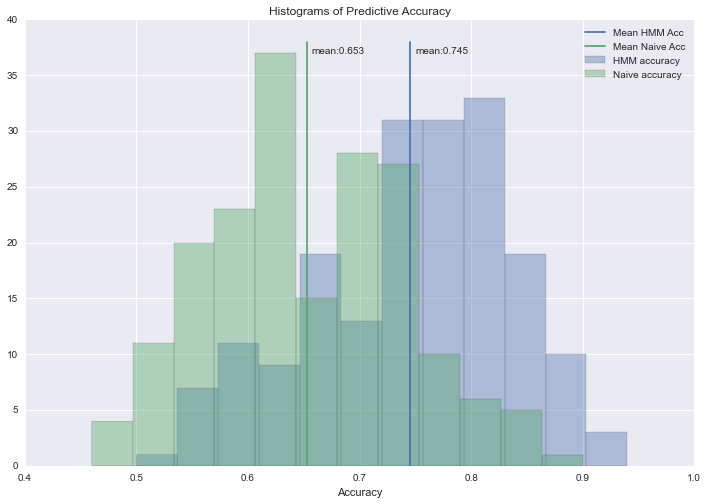

In [51]:
bins=12

fig = plt.figure(figsize=(12,8))
hmm_mean=np.mean(hmm_acc)
naive_mean=np.mean(naive_acc)

plt.hist(hmm_acc, label='HMM accuracy',alpha=0.4,bins=bins)
plt.hist(naive_acc, label='Naive accuracy',alpha=0.4,bins=bins)
plt.axvline(hmm_mean,0,0.95,label='Mean HMM Acc',color='#4C72B0')
plt.axvline(naive_mean,0,0.95,label='Mean Naive Acc',color='#55A868')
plt.annotate('mean:'+'%.3f' % hmm_mean, xy=(hmm_mean, 37), xytext=(hmm_mean+0.005, 37))
plt.annotate('mean:'+'%.3f' % naive_mean, xy=(naive_mean, 37), xytext=(naive_mean+0.005, 37))
plt.xlabel('Accuracy')
plt.title('Histograms of Predictive Accuracy')
plt.legend()
plt.show()

**Comments:**
    
Consider the simple measure of cost where we assign a cost of 0 for right predictions and a cost of 1 for any wrong predictions. Now looking at the histograms of cost for the two predictive methods, the conclusions are similar to those made about the accuracy histograms except we must remember that lower costs are preferred. The costs for the HMM predictions are generally lower and much more negatively skewed than the cost for naive predictions.

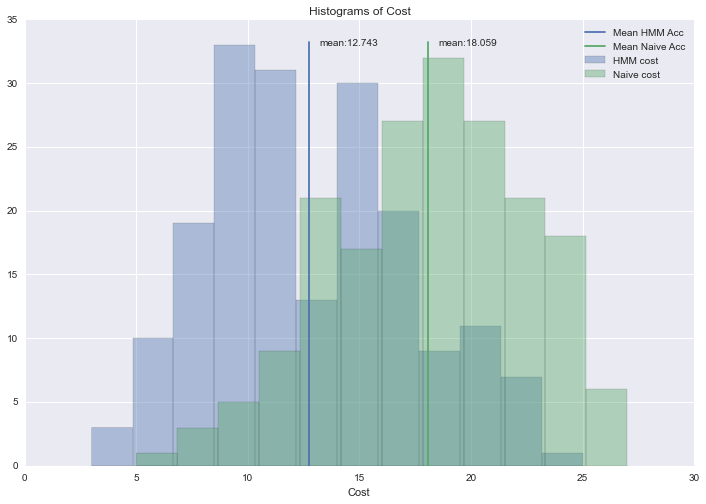

In [58]:
bins=12

fig = plt.figure(figsize=(12,8))
hmm_mean=np.mean(cost_hmm)
naive_mean=np.mean(cost_naive)

plt.hist(cost_hmm, label='HMM cost',alpha=0.4,bins=bins)
plt.hist(cost_naive, label='Naive cost',alpha=0.4,bins=bins)
plt.axvline(hmm_mean,0,0.95,label='Mean HMM Acc',color='#4C72B0')
plt.axvline(naive_mean,0,0.95,label='Mean Naive Acc',color='#55A868')
plt.annotate('mean:'+'%.3f' % hmm_mean, xy=(hmm_mean, 33), xytext=(hmm_mean+0.5, 33))
plt.annotate('mean:'+'%.3f' % naive_mean, xy=(naive_mean, 33), xytext=(naive_mean+0.5, 33))
plt.xlabel('Cost')
plt.title('Histograms of Cost')
plt.legend()
plt.show()

## Examples of Predicting Series

Below is an example of the predicted series and the actual series

In [80]:
times=np.append(times,24.00)

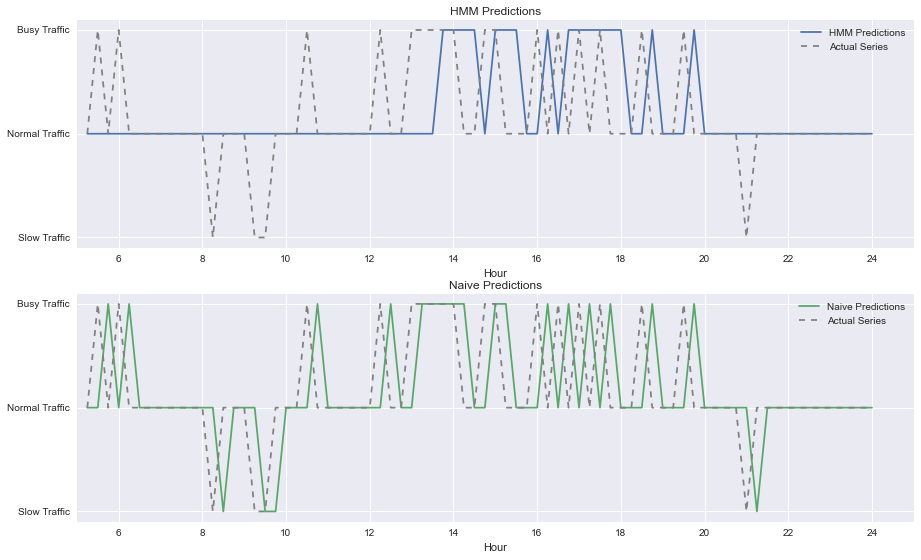

In [127]:
fig, ax = plt.subplots(2,figsize=(15,9))

ax[0].plot(times,hmm_series,label='HMM Predictions',color='#4C72B0')
ax[0].plot(times,actual_series,color='gray',linestyle='--',label='Actual Series')
ax[0].set_ylim([0.9,3.1])
ax[0].legend()
ax[0].set_title('HMM Predictions')
ax[0].xaxis.set_ticks([ t for t in times if t%2==0])
ax[0].yaxis.set_ticks([1,2,3])
ax[0].yaxis.set_ticklabels(['Slow Traffic','Normal Traffic','Busy Traffic'])
ax[0].set_xlabel('Hour')

ax[1].plot(times,naive_series,label='Naive Predictions',color='#55A868')
ax[1].plot(times,actual_series,color='gray',linestyle='--',label='Actual Series')
ax[1].set_ylim([0.9,3.1])
ax[1].legend()
ax[1].set_title('Naive Predictions')
ax[1].xaxis.set_ticks([ t for t in times if t%2==0])
ax[1].yaxis.set_ticks([1,2,3])
ax[1].yaxis.set_ticklabels(['Slow Traffic','Normal Traffic','Busy Traffic'])
ax[1].set_xlabel('Hour')
plt.show()

**Comments:**

Above is an example of how the HMM and naive methods perform on one day reserved in our test set. The naive method is just a lagged version of the actual series and is thus very sensitive to a sudden rise in ridership that regresses back to normal values in the next time period. For hours 16-18, this naive method incorrectly predicts the state at each time period because it fails to recognize that the station is in a high-traffic state. The HMM is not so sensitive to sporadic increases in ridership that return to normal levels in the next time period. It takes successive periods of high traffic in order for the HMM to detect that the station may be in a state of high-traffic, as observed between hours 12-14. Once the HMM starts to correctly predict 'Busy Traffic', it does not immediately return to predicting 'Normal Traffic' after the first time period where 'Normal Traffic' is observed. 

One way to interpret the difference between the HMM and naive methods is that the HMM takes longer to *heat up* or move out of a state of normal traffic where as the naive method quickly follows the traffic of the last time period.  Conversely, the HMM takes longer to *cool down* or come out of periods where it has predicted 'higher traffic' like between hours 16-20.

Even though the HMM fails to correctly predict the short spikes in ridership earlier in the test sample above, it's encouraging to see that it was properly trained to identify states of heightened traffic in the system. For future work, we would consider trying more hidden state/observed state combinations in order to capture finer details in the observed sequences. Theoretically, if we could further divide the traffic between normal ridership and busy ridership, the HMM might be able to detect periods of heightened ridership faster. Ideally, an HMM that predicts the numerical value of entries as opposed to the binned observation states of 'Busy', 'Normal, and 'Slow' might be easier to interpret. Such an HMM with numerical output could also transition between states easier as the observations would be continuous as opposed to the discrete bins we've created.

## Outputting Numerical Prediction of Entries
Below, we show one method we tried to output numerical values for the observed states taking the probability of each observed state as a weight on the mean of entries at a particular time period. Recall that we cardinalized the number of entries in each time period by binning the predicted output into 'lower than expected', 'expected', and 'greater than expected' numbers of entries denoted with 1,2, and 3, respectively. The predict_next_obs function outputs the probabilities of observing each state at time $t$ and the prediction was simply the state with the highest probability. Taking these probabilities, we can use them as weights to compute the predicted number of entries at time $t$.

Assume the HMM predicts the observed state at time $t$ with probabilities...
$$ P(y^{(t)}=1|H^{(t-1)},A,B)=0.1$$
$$ P(y^{(t)}=2|H^{(t-1)},A,B)=0.4$$
$$ P(y^{(t)}=3|H^{(t-1)},A,B)=0.5$$

By our previous method, we would predict observed state 3 at time $t$, but now we will use these as weights in a weighted average. The values they will be weighting are the mean number of entries in each observed state. The cell below shows the master table that computes the mean entries of each observed state $j$ at each time interval $t$ is $\mu_j^{(t)}$. For example, we can see at 6 a.m. that the lower 15% bin has a mean of 10.07 entries, the middle 70% bin has a mean of 22.23 entries, and the upper 15% bin has a mean of 32.5 entries. Using the hypothetical probabilities above, the predicted value at time $t=6$ would be 

$$ \hat{y}_t = \sum_{j=1}^m P(y_t=j|H^{(t-1)},A,B)*\mu_j^{(t)}$$
$$ = 0.1* 10.7+0.4*22.23+0.5*32.5$$
$$\hat{y}_t= 26.212$$

This is a better method because it does not simply ignore when two states have similar predicted probabilities and choose the higher one. It takes the uncertainty of the HMM and predicts based on the probabilities the HMM assigns to each state and the means of each observed state.

In [134]:
## These helper functions compute the mean of the entries in each observed state at each time period.
# These means will be weighted by the predicted probabilities of each observed state to generate a numerical
# prediction of entries

def mean_lower(a):
    cutoff=lower_fifteen(a)
    
    subset=a[a<=cutoff]
    return np.mean(subset)

def mean_middle(a):
    lower_cutoff=lower_fifteen(a)
    upper_cutoff=upper_fifteen(a)
    
    subset= a[(a>lower_cutoff)&(a<upper_cutoff)]
    
    return np.mean(subset)

def mean_upper(a):
    upper_cutoff=upper_fifteen(a)
    
    subset=a[a>=upper_cutoff]
    return np.mean(subset)
    
agg_sample=sample[['entries','servicetime_fraction']].groupby('servicetime_fraction').agg([mean_lower,mean_middle,mean_upper])

agg_sample=agg_sample.reset_index()
agg_sample.head()


servicetime_fraction     entries                         
                         mean_lower  mean_middle  mean_upper
0                  5.00    1.633540     4.261484    8.462500
1                  5.25   11.296703    22.120344   30.087379
2                  5.50    2.315315     6.124638   14.000000
3                  5.75    9.230769    19.304348   29.449438
4                  6.00   10.078652    22.237430   32.564356

In [136]:
# output the means to import in matlab

state_means=agg_sample['entries']
state_means.to_csv('obs_state_means.csv')

In [142]:
# output matrix of entries

obs_matrix=[]
entries_matrix=[]
for group in sample.groupby('servicedate'):
    ent=list(group[1]['entries'])

    if(len(ent)==76):
        entries_matrix.append(ent)
#sanity check
print len(entries_matrix)

with open("observed_states/obs_entries_1059.csv", "wb") as f:
    writer = csv.writer(f)
    writer.writerows(entries_matrix)

501


**Comments:**

The function below performs the prediction computation explained above. The naive prediction series is just the lagged series of actual entries.

In [162]:
## Import an example of the predicted series

naive_entries=np.genfromtxt('matlab_output/general_results/naive_entries.csv',delimiter=',',dtype=float)
hmm_entries=np.genfromtxt('matlab_output/general_results/hmm_entries.csv',delimiter=',',dtype=float)
actual_entries=np.genfromtxt('matlab_output/general_results/test_entries.csv',delimiter=',',dtype=float)


**Comments:**

Below you can see plots of the HMM predicted entries and the naive predicted entries. Note the smoothness of the HMM predictions and the way that it's able to accurately predict most of the peaks in the dataset. Looking at hours 12-14, the HMM does not descend into the valleys of low ridership following peaks that are significantly higher than traffic in the previous time period. The HMM predicts ridership somewhere between these two extremes and is a more reasonable prediction than the naive method which is very sensitive to these sudden drops and peaks in entries.

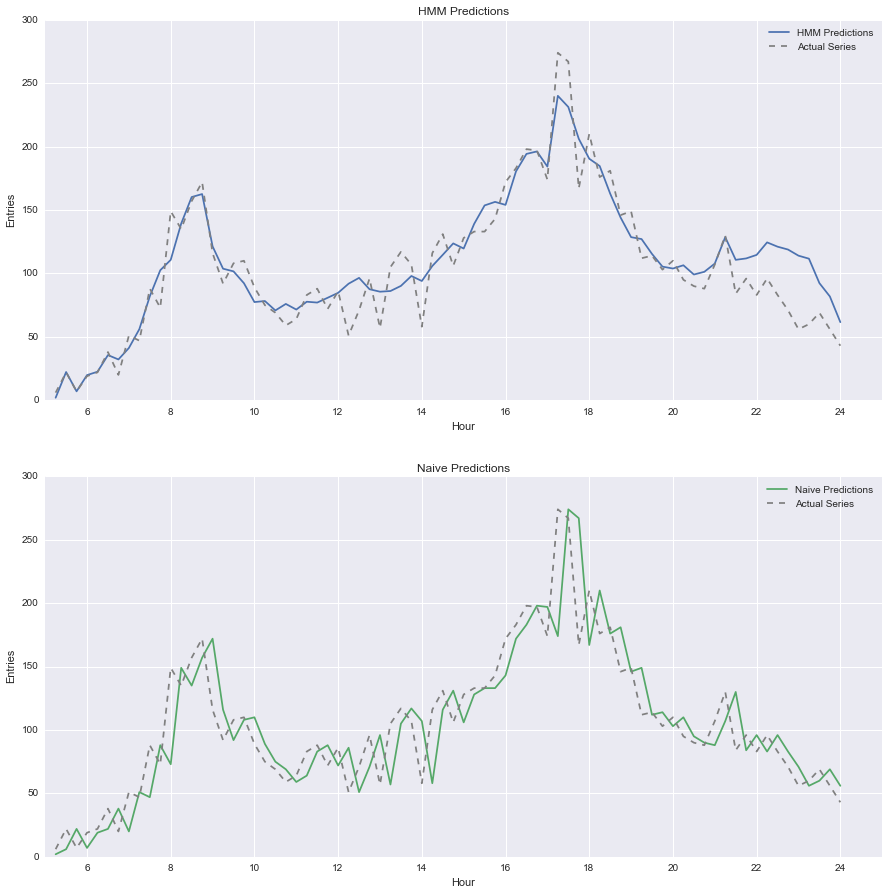

In [165]:
fig, ax = plt.subplots(2,figsize=(15,15))

ax[0].plot(times,hmm_entries,label='HMM Predictions',color='#4C72B0')
ax[0].plot(times,actual_entries,color='gray',linestyle='--',label='Actual Series')
ax[0].legend()
ax[0].set_title('HMM Predictions')
ax[0].xaxis.set_ticks([ t for t in times if t%2==0])
ax[0].set_xlabel('Hour')
ax[0].set_ylabel('Entries')


ax[1].plot(times,naive_entries,label='Naive Predictions',color='#55A868')
ax[1].plot(times,actual_entries,color='gray',linestyle='--',label='Actual Series')
ax[1].legend()
ax[1].set_title('Naive Predictions')
ax[1].xaxis.set_ticks([ t for t in times if t%2==0])
ax[1].set_xlabel('Hour')
ax[1].set_ylabel('Entries')

plt.show()

In [166]:
## Import SSR data

hmm_naive_ssr=np.genfromtxt('matlab_output/general_results/hmm_naive_ssr_ratio.csv',delimiter=',',dtype=float)
hmm_mean_ssr=np.genfromtxt('matlab_output/general_results/hmm_mean_ssr_ratio.csv',delimiter=',',dtype=float)


**Comments:**

One way to evaluate how well the numerical predictions perform on the whole dataset is to consider the Sum of Squared Residuals of the predicted values from the actual number of entries. We've imported two csv files containing the ratios of SSR for the HMM to both the naive method and the mean entries method. The mean entries method simply predicts that the entries at time $t$ are the mean of all days' entries at time $t$. Earlier in the notebook I showed an image that exhibited how the mean of all previous entries can be used to create a reasonable prediction of entries at any station for any time. The HMM should outperform this method since it incorporates both historical data through the training of the transition and emission matrices, but also takes into account the current state of the station.

Looking at the two histograms below, we see that in terms of SSR the HMM method outperforms the naive method on 73.63% of samples in the test set. Ratios less than 1 indicate that the SSR for HMM predictions was lower than the SSR for naive predictions. There are some extreme cases where the HMM method performs very poorly, but the histograms suggest that this HMM method is certainly an improvement over the naive method of predicting.

In the histogram of SSR ratios of the HMM and the mean entries methods, we can see that HMM predictions and the prediction of mean historical entries are not so unbalanced as the comparison of HMM to the naive method. The HMM outperforms the mean of historical entries in only 57% of test samples, but we can see that, in general, the two are fairly comparable. On some days, the HMM has SSR that are nearly a fifth of the SSR for the mean of historical entries prediction, while on some days the SSR of the HMM is around 80% larger than that of the mean of historical entries.

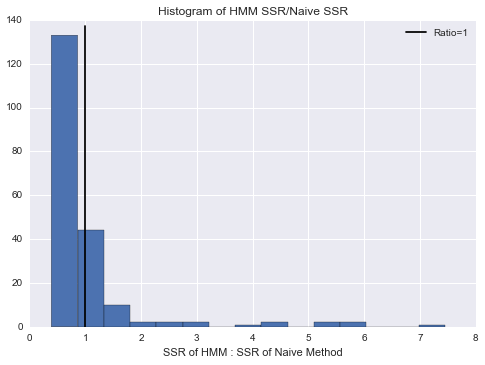

The HMM method had a lower SSR than the naive method on 73.63 percent of test samples


In [179]:
plt.hist(hmm_naive_ssr,bins=15)
plt.title('Histogram of HMM SSR/Naive SSR')
plt.xlabel('SSR of HMM : SSR of Naive Method')
plt.axvline(1,0,.98,color='black',label='Ratio=1')
plt.legend()

plt.show()

ratios_less_1=np.sum(hmm_naive_ssr<1)*1./len(hmm_naive_ssr)

print "The HMM method had a lower SSR than the naive method on %0.2f percent of test samples" %(ratios_less_1*100)

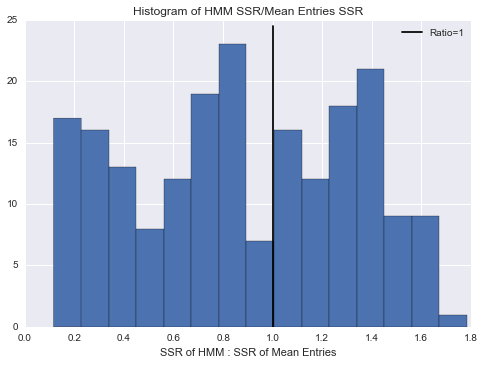

The HMM method had a lower SSR than the historical mean method on 57.21 percent of test samples


In [182]:
plt.hist(hmm_mean_ssr,bins=15)
plt.title('Histogram of HMM SSR/Mean Entries SSR')
plt.xlabel('SSR of HMM : SSR of Mean Entries')
plt.axvline(1,0,.98,color='black',label='Ratio=1')
plt.legend()

plt.show()

ratios_less_1=np.sum(hmm_mean_ssr<1)*1./len(hmm_mean_ssr)

print "The HMM method had a lower SSR than the historical mean method on %0.2f percent of test samples" %(ratios_less_1*100)

##Conclusions:

We've shown that HMMs are a viable method for predicting entries in real time. There is a fair amount of decisions to be made when training the HMM such as the number of hidden and observed states. There's no easy way to know how many states will provide enough detail for the HMM to converge to parameters that make sense. We searched several combinations and found 4 hidden and 3 observed states to be sufficient for our purposes. Future work will first have to concentrate on exhaustively training different sized HMMs. 

The cardinalized observed states of 'lower than expected', 'as expected', and 'busier than expected' traffic was a simplification that proved to outperform the naive method of predicting the observed state from the previous time period. Converting these predictions into numerical values for entries resulted in a much more intuitive and helpful means of showing HMM predictions. The HMM outperformed the naive method and the method that uses historical mean of entries at each time period, showing that this is indeed a viable manner of predicting ridership.